In [1]:
import cv2
from cv2 import SVDecomp
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


(800, 480)


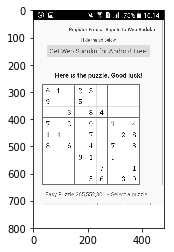

In [2]:
from PIL import Image

file = '/home/strahinja/Desktop/samsung_galaxy_j_1_mini/4.png'
image = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

label = file.rfind("/")
label = label + 1
label_1 = file.rfind(".")
sudoku_name = file[label : label_1]

start_image = image
img = image

print(img.shape)
plt.imshow(img, 'gray')

In [3]:
ret, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

# img = cv2.cvtColor(img,cv2)

# Binary adaptive threshold using 11 nearest neighbour pixels
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

img = cv2.bitwise_not(img, img)

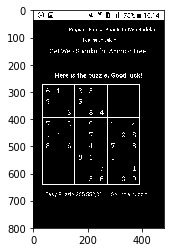

In [4]:
plt.imshow(img, cmap='gray')

In [5]:
kernel = (5,5)
img = cv2.dilate(img, kernel, iterations=1)

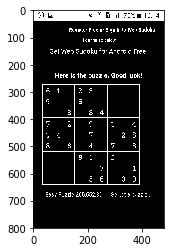

In [6]:
plt.imshow(img, cmap='gray')

In [7]:
_, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

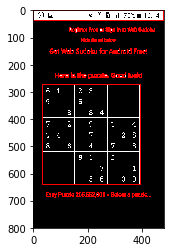

In [9]:
external_only = cv2.drawContours(img, contours, -1, (255, 0, 0), 2)
plt.imshow(external_only)

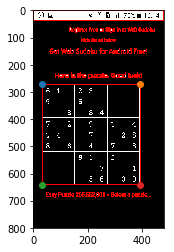

In [10]:
contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
contour = contours[0]
x,y,w,h = cv2.boundingRect(contour)
plt.imshow(img)
plt.scatter(x, y)
plt.scatter(x + w, y)
plt.scatter(x, y + h)
plt.scatter(x + w, y + h)

In [11]:
width = w
height = h

cell_size_x = width // 9
cell_size_y = h // 9

x_pos = x
y_pos = y
w = w
h = h

In [12]:
def distance_between(p1, p2):
    return np.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2))

In [13]:
top_left, top_right, bottom_right, bottom_left = (x,y), (x + w, y), (x + w, y + h), (x, y + h)

src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

side = max([
    distance_between(bottom_right, top_right),
    distance_between(top_left, bottom_left),
    distance_between(bottom_right, bottom_left),
    distance_between(top_left, top_right)
])

dst = np.array([[0, 0], [side, 0], [side, side], [0, side]], dtype='float32')

m = cv2.getPerspectiveTransform(src, dst)

img = cv2.warpPerspective(image, m, (int(side), int(side)))

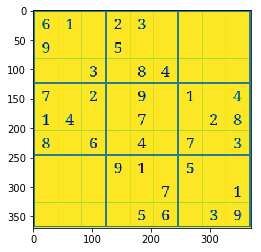

In [14]:
cv2.imwrite('processed.jpg', img)
plt.imshow(img)

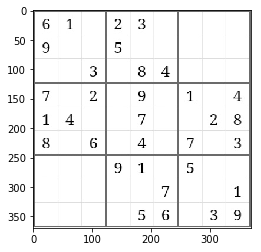

In [15]:
image = cv2.imread('processed.jpg')
plt.imshow(image)    

In [16]:
ret, img1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

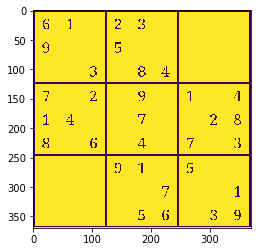

In [17]:
plt.imshow(img1)

In [18]:
def sort_horizontal (l):
    return l[0][1]

def sort_vertical (l):
    return l[0][0]

def calculate_new_horizontal(l_1, l_2, w):
    y = int((l_1[0][1] + l_2[0][1]) / 2)
    return [[0, y, w, y]]

def calculate_new_vertical(l_1, l_2, w):
    x = int((l_1[0][0] + l_2[0][0]) / 2)
    return [[x, 0, x, w]]

In [19]:
img = cv2.imread('processed.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1
theta = np.pi / 180
threshold = 20
min_line_length = 100
max_line_gap = 20
line_image = np.copy(img) * 0

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

horizontal = []
vertical = []
for line in lines:
    if line[0][1] == line[0][3]:
        horizontal.append(line)
    elif line[0][0] == line[0][2]:
        vertical.append(line)
        
horizontal.sort(key=sort_horizontal)

vertical.sort(key=sort_vertical)

horizontal_filtered = []
add_next = True
w = img.shape[0]

for i in range(0, len(horizontal) - 1):
    if horizontal[i + 1][0][1] - horizontal[i][0][1] < 10:
        horizontal_filtered.append(calculate_new_horizontal(horizontal[i], horizontal[i + 1], w))
        add_next = False
    else:
        if not add_next:
            add_next = True
        else:
            horizontal_filtered.append(horizontal[i])

if horizontal[len(horizontal) - 1][0][1] - horizontal[len(horizontal) - 2][0][1] < 10:
    horizontal_filtered.append(calculate_new_horizontal(horizontal[len(horizontal) - 2], horizontal[len(horizontal) - 1], w))
else:
    horizontal_filtered.append(horizontal[len(horizontal) - 1])
    
horizontal = np.array(horizontal_filtered)

vertical_filtered = []
add_next = True

for i in range(0, len(vertical) - 1):
    if vertical[i + 1][0][0] - vertical[i][0][0] < 10:
        vertical_filtered.append(calculate_new_vertical(vertical[i], vertical[i + 1], w))
        add_next = False
    else:
        if not add_next:
            add_next = True
        else:
            vertical_filtered.append(vertical[i])
            
if vertical[len(vertical) - 1][0][0] - vertical[len(vertical) - 2][0][0] < 10:
    vertical_filtered.append(calculate_new_vertical(vertical[len(vertical) - 2], vertical[len(vertical) - 1], w))
else:
    vertical_filtered.append(vertical[len(vertical) - 1])

vertical = np.array(vertical_filtered)

for line in horizontal:
    cv2.line(line_image,(line[0][0],line[0][1]),(line[0][2], line[0][3]),(255,0,0),3)
# cv2.line(line_image,(horizontal[7][0][0],horizontal[7][0][1]),(horizontal[7][0][2], horizontal[7][0][3]),(255,0,0),3)
    
for line in vertical:
    cv2.line(line_image,(line[0][0],line[0][1]),(line[0][2], line[0][3]),(255,0,0),3)
        
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

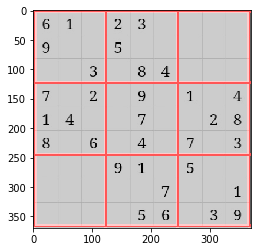

In [20]:
plt.imshow(lines_edges)

In [21]:
print('horizontal: ', len(horizontal))
print('vertical: ', len(vertical))

horizontal:  5
vertical:  4


In [22]:
def filter(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j][0] < 200 and image[i][j][1] < 200 and image[i][j][2] < 200:
                image[i][j] = 0
            else:
                image[i][j] = 255
    return image

def filter_1(image):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < 200:
                image[i][j] = 0
            else:
                image[i][j] = 255
    return image


In [23]:
from keras.models import load_model

model = load_model('/home/strahinja/Desktop/valjda_kraj/new_kraj/neural_unfiltered.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


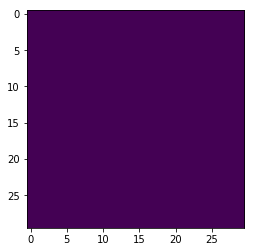

In [24]:
def prepare_image(im):
      
    image = np.copy(im)
        
    if (im.shape[0] > im.shape[1]):
        contour_movement = im.shape[0] // 6
        crop_movement = im.shape[0] // 40
    else:
        contour_movement = im.shape[1] // 6
        crop_movement = im.shape[0] // 40
        
    im = cv2.GaussianBlur(im,(1,1), 0)
    ret2, im = cv2.threshold(im, 130, 255, cv2.THRESH_BINARY)
    
    plt.imshow(im)
    
    _, contours, hierarchy = cv2.findContours(im, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending

    entered = False
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if x >= contour_movement and x < 4 * contour_movement:
            entered = True
            break
    
# # #     contour = contours[3]
# # #     x,y,w,h = cv2.boundingRect(contour)
    
    if len(contours) == 0 or len(contours) == 1 or entered == False:
        im = cv2.resize(im, (30, 30) , interpolation = cv2.INTER_AREA)
        im [ : , : ] = 0
        im = cv2.bitwise_not(im, im)
        return im

    image = image[y - crop_movement : y + h + crop_movement, x - crop_movement : x + w + crop_movement]
    
    image = cv2.resize(image, (30, 30) , interpolation = cv2.INTER_LINEAR)
    ret2, im = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
    
#     print(len(contours), x, y, w, h)
#     plt.scatter(x - 1, y - 1)
#     plt.scatter(x + w + 1, y - 1)
#     plt.scatter(x - 1, y + h + 1)
#     plt.scatter(x + w + 1, y + h + 1)
#     plt.imshow(im)
    
    im = cv2.bitwise_not(im, im)
    image = cv2.bitwise_not(image, image)
    
    return image


x_cell = 0
y_cell = 6

# nmb = 5
# sudoku_number = 20

img = start_image[y_pos + x_cell * cell_size_y : y_pos + (x_cell + 1) * cell_size_y, 
              x_pos + y_cell * cell_size_x : x_pos + (y_cell + 1) * cell_size_x]

img = prepare_image(img)

plt.imshow(img)

# print(np.argmax(model.predict(img.reshape(1, 30, 30, 1))))

# # print(image)
# import matplotlib
# # for i in range(0, 21):
# # matplotlib.image.imsave('/home/strahinja/Desktop/valjda_kraj/new_kraj/digits/' + str(sudoku_number) + '_' + str(nmb) + '.png', img)
# # matplotlib.image.imsave('/home/strahinja/Desktop/valjda_kraj/new_kraj/filtered_digits/' + str(sudoku_number) + '_' + str(nmb) + '.png', img1)
# # print(img)

# # print(img)
# plt.imshow(img, cmap = 'gray')

In [25]:
def predict_number(model, img):
    from PIL import Image
#     from resizeimage import resizeimage
    
#     img = cv2.resize(img, (30, 30), interpolation = cv2.INTER_AREA)
#     img = np.array(img)
#     img = cv2.resize(img, (30, 30) , interpolation = cv2.INTER_NEAREST)
#     img = prepare_image(img)

    img = prepare_image(img)
    
#     Ako ne radis sa onim cudnim slikama treba ovo
#     img = np.mean(img, axis = 2)
    
    prediction = model.predict(img.reshape(1, 30, 30, 1))
    
    value = img[0, 0]
    
    pom = img == value
    
    if np.all(pom):
        return 0
    
    return np.argmax(prediction)

# plt.imshow(im)

# print(predict_number(model, im))

In [26]:
# x = 0
# y = 7

# image = img[vertical[x][0][0] : vertical[x + 1][0][0], 
#                     horizontal[y][0][1] : horizontal[y + 1][0][1]]

# plt.imshow(image)

# predict_number(model, image)

In [27]:
sudoku = [[], [], [], [], [], [], [], [], []]
sudoku_pom = [[], [], [], [], [], [], [], [], []]

[[6 1 0 2 3 0 0 0 0]
 [9 0 0 5 0 0 0 0 0]
 [0 0 3 0 8 4 0 0 0]
 [7 0 2 0 9 0 1 0 4]
 [1 4 0 0 7 0 0 2 8]
 [8 0 6 0 4 0 7 0 3]
 [0 0 0 9 1 0 5 0 0]
 [0 0 0 0 0 7 0 0 1]
 [0 0 0 0 5 6 0 3 9]]


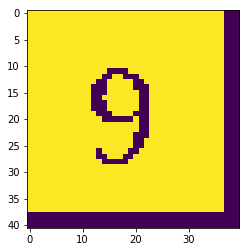

In [28]:
cell_size = img.shape[0] // 9

for i in range(0, 9):
    for j in range(0, 9):            
        image = start_image[y_pos + i * cell_size_y : y_pos + (i + 1) * cell_size_y, 
              x_pos + j * cell_size_x : x_pos + (j + 1) * cell_size_x]
        sudoku[i].append(predict_number(model, image))
        sudoku_pom[i].append(predict_number(model, image))

print(np.matrix(sudoku))

In [29]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [30]:
def check_row(sudoku, i, number):
    for j in range(9):
        if sudoku[i][j] == number:
            return False
    return True

In [31]:
def check_column(sudoku, j, number):
    for i in range(9):
        if (sudoku[i][j] == number):
            return False
    return True

In [32]:
def check_square(sudoku, i, j, number):
    row = int(i / 3)
    column = int(j / 3)
    
    m = int(3 * (row + 1))
    n = int(3 * (column + 1))
    
    for i in range(int(3 * row), m):
        for j in range(int(3 * column), n):
            if sudoku[i][j] == number:
                return False

    return True

In [33]:
def finished(sudoku):
    for i in range(9):
        for j in range(9):
            if (sudoku[i][j] == 0):
                return False

    return True

In [34]:
def solve(sudoku, i, j):
    if (sudoku[i][j] == 0):
        for k in range(1, 10):
            if (check_row(sudoku, i, k) and check_column(sudoku, j, k) and check_square(sudoku, i, j, k)):
                sudoku[i][j] = k

                if (finished(sudoku)):
                    raise StopExecution

                if (j == 8):
                    solve(sudoku, i + 1, 0)
                else:
                    solve(sudoku, i, j + 1)

                sudoku[i][j] = 0
    else:
        if (j == 8):
            solve(sudoku, i + 1, 0)
        else:
            solve(sudoku, i, j + 1)

In [35]:
solve(sudoku, 0, 0)

In [36]:
print(np.matrix(sudoku))

[[6 1 7 2 3 9 4 8 5]
 [9 8 4 5 6 1 3 7 2]
 [5 2 3 7 8 4 9 1 6]
 [7 3 2 6 9 8 1 5 4]
 [1 4 9 3 7 5 6 2 8]
 [8 5 6 1 4 2 7 9 3]
 [2 6 8 9 1 3 5 4 7]
 [3 9 5 4 2 7 8 6 1]
 [4 7 1 8 5 6 2 3 9]]


In [37]:
print(np.matrix(sudoku_pom))

[[6 1 0 2 3 0 0 0 0]
 [9 0 0 5 0 0 0 0 0]
 [0 0 3 0 8 4 0 0 0]
 [7 0 2 0 9 0 1 0 4]
 [1 4 0 0 7 0 0 2 8]
 [8 0 6 0 4 0 7 0 3]
 [0 0 0 9 1 0 5 0 0]
 [0 0 0 0 0 7 0 0 1]
 [0 0 0 0 5 6 0 3 9]]


In [38]:
solution_image = image = cv2.imread('/home/strahinja/Desktop/empty_sudoku.jpg')
solution_image = cv2.resize(solution_image, (1024, 1024) , interpolation = cv2.INTER_AREA)

cell_size_y = solution_image.shape[0] // 9
cell_size_x = solution_image.shape[1] // 9

distance = cell_size_x // 5

# print(solution_image.shape)
# plt.imshow(solution_image)

for i in range(0, 9):
    for j in range(0, 9):
        shape = solution_image[i * cell_size_y + distance : (i + 1) * cell_size_y - distance, 
          j * cell_size_x + distance : (j + 1) * cell_size_x - distance].shape[0:2]
        
        if (sudoku_pom[i][j] == 0):
            digit_image = Image.open('./solution_digits/' + str(sudoku[i][j]) + '.png').convert('RGB')
        else:
            digit_image = Image.open('./solution_digits/' + str(sudoku[i][j]) + '.png').convert('RGB')
        digit_image = np.array(digit_image)

        digit_image = cv2.resize(digit_image, (shape[1], shape[0]), interpolation = cv2.INTER_AREA)

        solution_image[i * cell_size_y + distance : (i + 1) * cell_size_y - distance, 
          j * cell_size_x + distance : (j + 1) * cell_size_x - distance] = digit_image

[[6 1 0 2 3 0 0 0 0]
 [9 0 0 5 0 0 0 0 0]
 [0 0 3 0 8 4 0 0 0]
 [7 0 2 0 9 0 1 0 4]
 [1 4 0 0 7 0 0 2 8]
 [8 0 6 0 4 0 7 0 3]
 [0 0 0 9 1 0 5 0 0]
 [0 0 0 0 0 7 0 0 1]
 [0 0 0 0 5 6 0 3 9]]


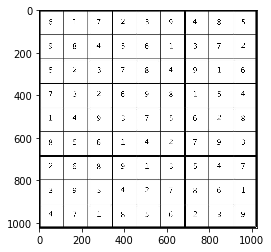

In [41]:
print(np.matrix(sudoku_pom))
# plt.imshow(img)
plt.imshow(solution_image)

In [42]:
import matplotlib
matplotlib.image.imsave('./' + sudoku_name + '_solution.png', solution_image)